# GPU Ocean Tutorial - Deterministic Trajectory Forecast

In [1]:
#Lets have matplotlib "inline"
%matplotlib inline

import os
import sys

#Import packages we need
import numpy as np
from netCDF4 import Dataset
import datetime
from IPython.display import display

#For plotting
import matplotlib
from matplotlib import pyplot as plt

GPU Ocean-modules:

In [2]:
from gpuocean.SWEsimulators import CDKLM16
from gpuocean.utils import Common, IPythonMagic, NetCDFInitialization, Observation, GPUOcean_runDeterministic
from gpuocean.drifters import GPUDrifterCollection
from gpuocean.dataassimilation import DataAssimilationUtils as dautils

In [3]:
%cuda_context_handler gpu_ctx

## Selecting area and loading initial- and boundary conditions

In [4]:
source_url = '/sintef/data/NorKyst800/NorKyst-800m_ZDEPTHS_his.an.2019071600.nc'

In [5]:
casename = 'lofoten'
data_args = NetCDFInitialization.getInitialConditionsNorKystCases(source_url,casename, download_data=False)

In [6]:
sim_args = {
    "gpu_ctx": gpu_ctx,
    "dt": 0.0,
     }

sim = CDKLM16.CDKLM16(**sim_args, **NetCDFInitialization.removeMetadata(data_args))

This will give inaccurate angle along the border!
This will give inaccurate coriolis along the border!


In [7]:
observation_args = {'observation_type': dautils.ObservationType.UnderlyingFlow,
                'nx': sim.nx, 'ny': sim.ny,
                'domain_size_x': sim.nx*sim.dx,
                'domain_size_y': sim.ny*sim.dy,
                'land_mask': sim.getLandMask()
               }

forecast = Observation.Observation(**observation_args)

## Creating drifters

In [8]:
num_drifters = 3
drifters = GPUDrifterCollection.GPUDrifterCollection(gpu_ctx, num_drifters, 
                                                 boundaryConditions = sim.boundary_conditions,
                                                 domain_size_x = forecast.domain_size_x,
                                                 domain_size_y = forecast.domain_size_y,
                                                 gpu_stream = sim.gpu_stream)


In [9]:
init_positions = np.array([[196790, 148550],  #[[x1, y1],
                           [217930, 80860],  # [x2, y2],
                           [104890, 146440]]) # [x3, y3]]
drifters.setDrifterPositions(init_positions)

## Running the simulation

In [10]:
start_drifters_hours = 5
total_hours = 24
dt = 5*60 # Stepsize: 5min (in seconds)
timesteps_per_hour = int(60*60 / dt)

#Create progress bar
progress = Common.ProgressPrinter(5)
pp = display(progress.getPrintString(0), display_id=True)

#Run simulation
for hour in range(total_hours):
    
    if hour == start_drifters_hours:                  #Attach drifters 
        sim.attachDrifters(drifters)
        forecast.add_observation_from_sim(sim)
    
    for n in range(timesteps_per_hour):    
        t = sim.step(dt)                              #make one step forward in time
        if hour >= start_drifters_hours:               #Add positions to observation only if drifters have been attached
            forecast.add_observation_from_sim(sim) 
    
    #Update progress bar
    pp.update(progress.getPrintString(hour/(total_hours-1)))

'0% [##############################] 100%. Total: 30s, elapsed: 30s, remaining: 0s'

## Changing Resolution

In [11]:
#Rescaling initial conditions
data_args_doubleres =  NetCDFInitialization.rescaleInitialConditions(data_args, scale = 2)


#Setting up simulator, observation, drifters and running as above
sim_doubleres = CDKLM16.CDKLM16(**sim_args, **NetCDFInitialization.removeMetadata(data_args_doubleres))

observation_args_doubleres = {'observation_type': dautils.ObservationType.UnderlyingFlow,
                                'nx': sim_doubleres.nx, 'ny': sim_doubleres.ny,
                                'domain_size_x': sim_doubleres.nx*sim_doubleres.dx,
                                'domain_size_y': sim_doubleres.ny*sim_doubleres.dy,
                                'land_mask': sim_doubleres.getLandMask()
                               }

forecast_doubleres = Observation.Observation(**observation_args_doubleres)

drifters_doubleres = GPUDrifterCollection.GPUDrifterCollection(gpu_ctx, num_drifters, 
                                                                 boundaryConditions = sim_doubleres.boundary_conditions,
                                                                 domain_size_x = forecast_doubleres.domain_size_x,
                                                                 domain_size_y = forecast_doubleres.domain_size_y,
                                                                 gpu_stream = sim_doubleres.gpu_stream)

drifters_doubleres.setDrifterPositions(init_positions) #Same initial positions as above

#Running simulation
#Create new progress bar
progress = Common.ProgressPrinter(5)
pp = display(progress.getPrintString(0), display_id=True)

#Run simulation
for hour in range(total_hours):
    
    if hour == start_drifters_hours:                  #Attach drifters 
        sim_doubleres.attachDrifters(drifters_doubleres)
        forecast_doubleres.add_observation_from_sim(sim_doubleres)
    
    for n in range(timesteps_per_hour):    
        t = sim_doubleres.step(dt)                              #make one step forward in time
        if hour >= start_drifters_hours:               #Add positions to observation only if drifters have been attached
            forecast_doubleres.add_observation_from_sim(sim_doubleres) 
    
    #Update progress bar
    pp.update(progress.getPrintString(hour/(total_hours-1)))

This will give inaccurate angle along the border!
This will give inaccurate coriolis along the border!


'0% [##############################] 100%. Total: 1m 0s, elapsed: 1m 0s, remaining: 0s'

In [12]:
#Rescaling initial conditions
data_args_tripleres =  NetCDFInitialization.rescaleInitialConditions(data_args, scale = 3)


#Setting up simulator, observation, drifters and running as above
sim_tripleres = CDKLM16.CDKLM16(**sim_args, **NetCDFInitialization.removeMetadata(data_args_tripleres))

observation_args_tripleres = {'observation_type': dautils.ObservationType.UnderlyingFlow,
                                'nx': sim_tripleres.nx, 'ny': sim_tripleres.ny,
                                'domain_size_x': sim_tripleres.nx*sim_tripleres.dx,
                                'domain_size_y': sim_tripleres.ny*sim_tripleres.dy,
                                'land_mask': sim_tripleres.getLandMask()
                               }

forecast_tripleres = Observation.Observation(**observation_args_tripleres)

drifters_tripleres = GPUDrifterCollection.GPUDrifterCollection(gpu_ctx, num_drifters, 
                                                                 boundaryConditions = sim_doubleres.boundary_conditions,
                                                                 domain_size_x = forecast_tripleres.domain_size_x,
                                                                 domain_size_y = forecast_tripleres.domain_size_y,
                                                                 gpu_stream = sim_tripleres.gpu_stream)

drifters_tripleres.setDrifterPositions(init_positions) #Same initial positions as above

#Running simulation
#Create new progress bar
progress = Common.ProgressPrinter(5)
pp = display(progress.getPrintString(0), display_id=True)

#Run simulation
for hour in range(total_hours):
    
    if hour == start_drifters_hours:                  #Attach drifters 
        sim_tripleres.attachDrifters(drifters_tripleres)
        forecast_tripleres.add_observation_from_sim(sim_tripleres)
    
    for n in range(timesteps_per_hour):    
        t = sim_tripleres.step(dt)                              #make one step forward in time
        if hour >= start_drifters_hours:               #Add positions to observation only if drifters have been attached
            forecast_tripleres.add_observation_from_sim(sim_tripleres) 
    
    #Update progress bar
    pp.update(progress.getPrintString(hour/(total_hours-1)))

This will give inaccurate angle along the border!
This will give inaccurate coriolis along the border!


'0% [##############################] 100%. Total: 3m 9s, elapsed: 3m 9s, remaining: 0s'

## Comparing trajectories

/home/florianb/havvarsel/gpuocean/src/gpuocean/utils/GPUOcean_runDeterministic.py:435: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("YlOrRd"))
  v_cmap.set_bad(land_color, alpha = 1.0)


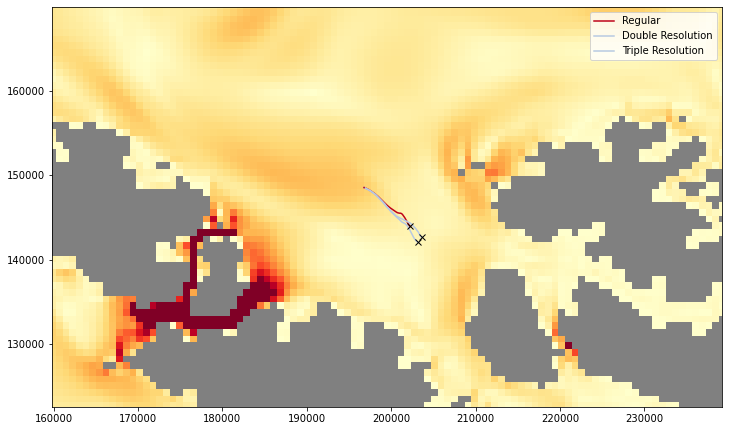

In [13]:
domain = [1400, 1900, 450, 750]
ax = GPUOcean_runDeterministic.createForecastCanvas(forecast,background = True, url= source_url,
                                                    domain = domain, zoom= 5)
GPUOcean_runDeterministic.plotAllDrifters(forecast, drifter_ids = [0], ax = ax, color_id = 0, label="Regular")
GPUOcean_runDeterministic.plotAllDrifters(forecast_doubleres, drifter_ids = [0], ax = ax, color_id = 1, label= "Double Resolution") 
GPUOcean_runDeterministic.plotAllDrifters(forecast_tripleres, drifter_ids = [0], ax = ax, color_id = 1, label= "Triple Resolution") 
ax.legend()

/home/florianb/havvarsel/gpuocean/src/gpuocean/utils/GPUOcean_runDeterministic.py:435: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("YlOrRd"))
  v_cmap.set_bad(land_color, alpha = 1.0)


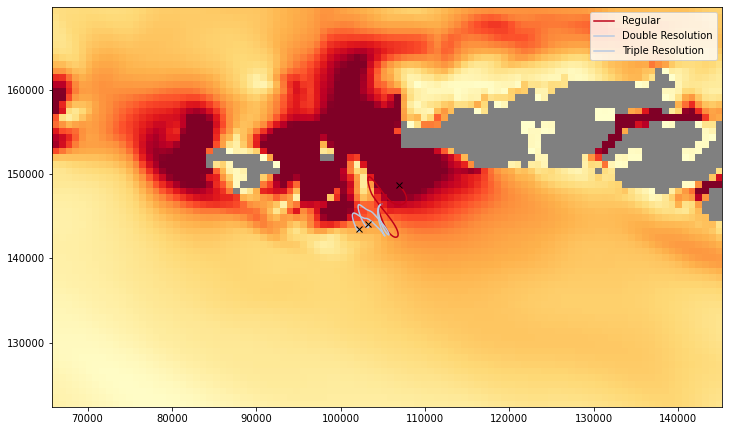

In [14]:
ax = GPUOcean_runDeterministic.createForecastCanvas(forecast,background = True, url= source_url,
                                                    domain = domain, zoom= 5, zoom_element=2)
GPUOcean_runDeterministic.plotAllDrifters(forecast, drifter_ids = [2], ax = ax, color_id = 0, label="Regular")
GPUOcean_runDeterministic.plotAllDrifters(forecast_doubleres, drifter_ids = [2], ax = ax, color_id = 1, label= "Double Resolution") 
GPUOcean_runDeterministic.plotAllDrifters(forecast_tripleres, drifter_ids = [2], ax = ax, color_id = 1, label= "Triple Resolution") 
ax.legend()

## Data from Norfjords160

Norfjords160 provides higher-resolution data for certain areas along the coast. As the file format is different, an extra argument <code>norkyst = False</code> needs to be passed to <code>NetCDFInitialization.getInitialConditions()</code>. The indices defining the domain are also different as the covered area is different. Otherwise, everything is the same.

Finally, the function <code> GPUOcean_runDeterministic.simulate_gpuocean_deterministic </code> lets you run simulations like the ones above with one function call. It takes in a source_url, domain($[x_0,x_1,y_0,y_1]$), initial positions, sim_args and optional wind-drift,scaling factors and boolean parameter for norfjords-data and returns an Observation object with the forecast. A small example that also demonstrated the Norfjords160-data is given below. See OpendriftParcels/Compare_Example.ipynb for more.

In [15]:
from importlib import reload
reload(GPUOcean_runDeterministic)
#local file path
norfjords160 = '/sintef/data/NorFjords160/A10/norfjords_160m_his.nc4_2019071601-2019071700'

assert os.path.isfile(norfjords160), "NorFjord160 data is not public, and you therefore need to modify the local path if you have the data available"

#Using xygpuocean2lonlat, we find the initail positions of the first drifter in lon/lat coordinates
initlon, initlat = GPUOcean_runDeterministic.xygpuocean2lonlat(source_url, init_positions[:,0], init_positions[:,1], 1400, 450)
print('lon:', initlon, ", lat: ", initlat)

#Use these to find initial positions and define area for Norfjords160 data
#Set norkyst= False
xinit, yinit, x0, x1, y0, y1 = GPUOcean_runDeterministic.initlonlat2initgpuocean(norfjords160, initlon, initlat, 
                                                       norkyst = False, num_cells_x = 400, num_cells_y = 250)
domain = [x0,x1,y0,y1]

#Set sim_args and run norfjords forecast
sim_args = {
    "gpu_ctx": gpu_ctx,
    "dt": 0.0,
     }
norfjords_forecast = GPUOcean_runDeterministic.simulate_gpuocean_deterministic(norfjords160, domain, list(xinit), list(yinit), sim_args = sim_args,
                                                    norkyst_data = False)

lon: [14.20004766 15.89992399 12.97997887] , lat:  [68.49998894 68.30001104 67.77998254]


This will give inaccurate angle along the border!
This will give inaccurate coriolis along the border!


'0% [##############################] 100%. Total: 44s, elapsed: 44s, remaining: 0s'

In [16]:
norfjords_forecast_halfres = GPUOcean_runDeterministic.simulate_gpuocean_deterministic(norfjords160, domain, list(xinit), list(yinit), sim_args = sim_args,
                                                    rescale=0.5, norkyst_data = False)

This will give inaccurate angle along the border!
This will give inaccurate coriolis along the border!


'0% [##############################] 100%. Total: 22s, elapsed: 22s, remaining: 0s'

## Comparing simulations with different domains

To directly compare trajectories found using initial data from Norfjords160 and Norkyst800, they need to be within the same coordinate system, given in distance in m from the same reference point. The function <code> GPUOcean_runDeterministic.norkyst2norfjords</code> takes in urls to norkyst and norfjords data as well as both observations and x0, y0 -values of the domains. It returns a new observation with the trajectories from the observation based on norkyst data, but placed within the same reference system as the observation based on norfjords-data. These can then be plotted together as before.

In [17]:
#Printing norfjords-domain:
print("Domain norfjords_forecast:\nx0: ",x0,', x1: ',x1,', y0: ', y0,', y1: ',y1)

Domain norfjords_forecast:
x0:  1038 , x1:  1438 , y0:  715 , y1:  965


In [18]:
norkyst_new = GPUOcean_runDeterministic.norkyst2norfjords(norfjords_obs = norfjords_forecast, norkyst_obs = forecast, 
                                                            norfjords_url = norfjords160, norkyst_url = source_url, 
                                                            norfjords_x0 = 1038, norfjords_y0 = 715, 
                                                            norkyst_x0 = 1400, norkyst_y0 = 450)


norkyst_new_doubleres = GPUOcean_runDeterministic.norkyst2norfjords(norfjords_obs = norfjords_forecast, norkyst_obs = forecast_doubleres, 
                                                            norfjords_url = norfjords160, norkyst_url = source_url, 
                                                            norfjords_x0 = 1038, norfjords_y0 = 715, 
                                                            norkyst_x0 = 1400, norkyst_y0 = 450)         

norkyst_new_tripleres = GPUOcean_runDeterministic.norkyst2norfjords(norfjords_obs = norfjords_forecast, norkyst_obs = forecast_tripleres, 
                                                            norfjords_url = norfjords160, norkyst_url = source_url, 
                                                            norfjords_x0 = 1038, norfjords_y0 = 715, 
                                                            norkyst_x0 = 1400, norkyst_y0 = 450)                                                      

/home/florianb/havvarsel/gpuocean/src/gpuocean/utils/GPUOcean_runDeterministic.py:435: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("YlOrRd"))
  v_cmap.set_bad(land_color, alpha = 1.0)


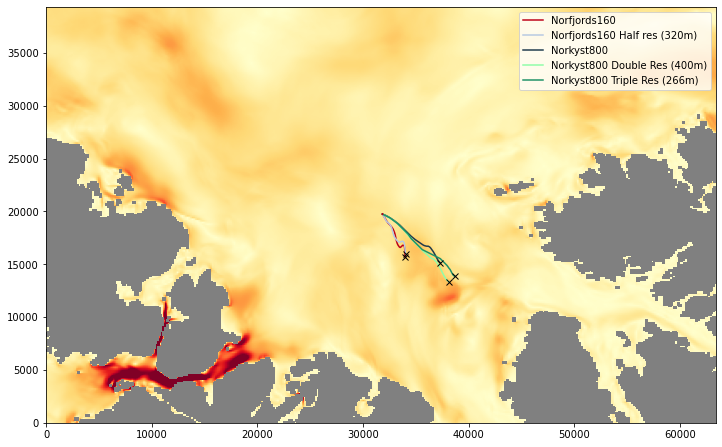

In [22]:
for d in range(1):
    ax = GPUOcean_runDeterministic.createForecastCanvas(norfjords_forecast,background = True, url= norfjords160,
                                                        domain = domain, zoom= 1, zoom_element=0)
    GPUOcean_runDeterministic.plotAllDrifters(norfjords_forecast, ax = ax, drifter_ids =[d], color_id = 0, label="Norfjords160")
    GPUOcean_runDeterministic.plotAllDrifters(norfjords_forecast_halfres, ax = ax, drifter_ids =[d], color_id = 1, label="Norfjords160 Half res (320m)")
    GPUOcean_runDeterministic.plotAllDrifters(norkyst_new, ax = ax,drifter_ids =[d] , color_id = 2, label="Norkyst800")
    GPUOcean_runDeterministic.plotAllDrifters(norkyst_new_doubleres, ax = ax,drifter_ids =[d] , color_id = 3, label="Norkyst800 Double Res (400m)")
    GPUOcean_runDeterministic.plotAllDrifters(norkyst_new_tripleres, ax = ax,drifter_ids =[d] , color_id = 4, label="Norkyst800 Triple Res (266m)")
    ax.legend()